# Проект: 2 вариант, задание 1

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.stats as stats
import pingouin as pg
from statsmodels.stats import proportion as prop

sns.set(rc={'figure.figsize':(12,8)})

Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа):

In [79]:
groups = pd.read_csv('2_groups.csv', sep=';')
groups.shape

(74484, 2)

In [80]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [81]:
group_add = pd.read_csv('2_group_add.csv')
group_add.shape

(92, 2)

In [82]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

In [83]:
active_studs = pd.read_csv('2_active_studs.csv')
active_studs.shape

(8341, 1)

In [84]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [85]:
checks = pd.read_csv('2_checks.csv', sep=';')
checks.shape

(541, 2)

In [86]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


## Определимся с метриками

<b>Целевая</b> метрика - средний чек на платящего пользователя (ARPPU)

Будем считать:

$H_0$: ARPPU в обоих группах примерно равен

$H_1$: ARPPU увеличился для теста

Возьмем уровень значимости 0.05

<b>Guardrail</b> метрика - Retention

Будем считать:

$H_0$: Retention не упал ($Retention_B \ge Retention_A$)

$H_1$: Retention упал ($Retention_B < Retention_A$)

(Проверяем именно такую альтернативу, потому что retention в данном эксперименте - метрика, которую нельзя ронять)

Возьмем уровень значимости 0.05

### Целевая метрика

In [87]:
# Добавим файл с новыми данными
groups_full = groups.append(group_add)
groups_full.shape

(74576, 2)

In [88]:
# Определим группы платящих пользователей
payed_users = groups_full.merge(checks, how='right', left_on='id', right_on='student_id')
payed_users.shape

(541, 4)

In [89]:
payed_users.head()

,id,grp,student_id,rev
0,1627,A,1627,990.0
1,3185,B,3185,690.0
2,25973,B,25973,690.0
3,26280,B,26280,690.0
4,100300,B,100300,990.0


Проверим данные на нормальность

Сначала построим графики распределений выручки по группам

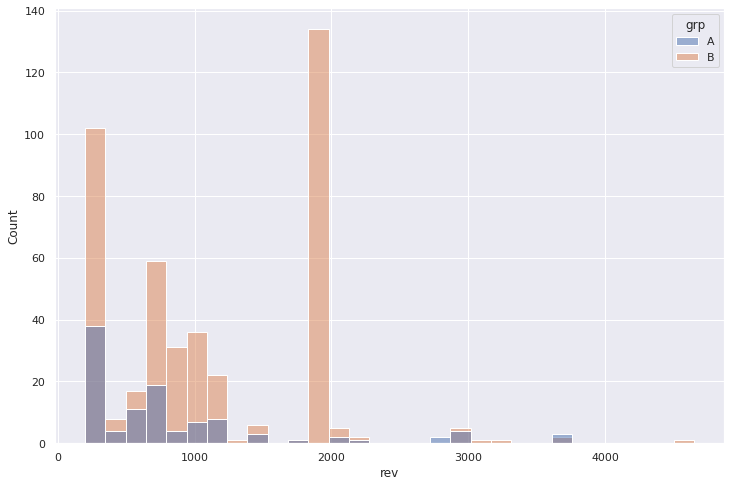

In [90]:
sns.histplot(data=payed_users, x='rev', hue='grp', bins=30);

Затем проведем тесты на нормальность и гомоскедантичность

In [91]:
stats.normaltest(payed_users.query('grp == "A"')['rev']), stats.normaltest(payed_users.query('grp == "B"')['rev'])

(NormaltestResult(statistic=52.21845240353401, pvalue=4.580439316510776e-12),
 NormaltestResult(statistic=33.19587456725772, pvalue=6.18881394639434e-08))

In [92]:
pg.homoscedasticity(data=payed_users, dv='rev', group='grp')

,W,pval,equal_var
levene,4.478901,0.034774,False


После неудачных тестов на нормальность и гомоскедантичность, попробуем трансформировать переменную прибыли, например прологарифмировать. Повторим действия, проведенные выше

In [93]:
payed_users['log_rev'] = np.log(payed_users['rev'])
payed_users.head()

,id,grp,student_id,rev,log_rev
0,1627,A,1627,990.0,6.897705
1,3185,B,3185,690.0,6.536692
2,25973,B,25973,690.0,6.536692
3,26280,B,26280,690.0,6.536692
4,100300,B,100300,990.0,6.897705


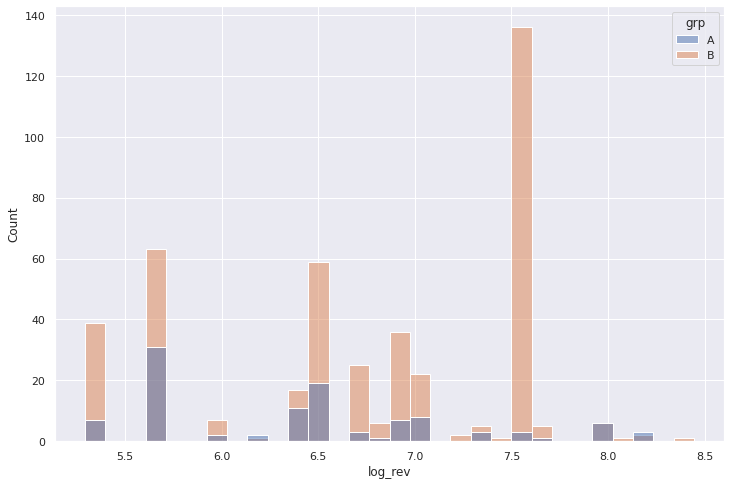

In [94]:
sns.histplot(data=payed_users, x='log_rev', hue='grp', bins=30);

In [95]:
stats.normaltest(payed_users.query('grp == "A"')['log_rev']), stats.normaltest(payed_users.query('grp == "B"')['log_rev'])

(NormaltestResult(statistic=6.233410724754571, pvalue=0.044302890206508495),
 NormaltestResult(statistic=121.52506435050901, pvalue=4.0847696422045564e-27))

In [96]:
pg.homoscedasticity(data=payed_users, dv='log_rev', group='grp')

,W,pval,equal_var
levene,1.06454,0.302645,True


Как видно ни одно распределение не похоже на нормальное (и по графику, и по тесту), хоть и удовлетворяют условию одинаковых дисперсий. Поэтому будем использовать непараметрический аналог сравнения средних - тест Манна-Уитни (тест на различия распределений)

In [97]:
# Используем правостороннюю альтернативу, так как ожидаем увеличение в тестовой группе по сравнению с контрольной
stats.mannwhitneyu(payed_users.query('grp == "B"')['rev'], payed_users.query('grp == "A"')['rev'], alternative='greater')

MannwhitneyuResult(statistic=28576.0, pvalue=9.658027498190076e-05)

In [98]:
# Посчитаем ARPPU вручную
payed_users.groupby('grp').agg({'rev':'mean'})

,rev
grp,
A,860.710280
B,1108.824893


Исходя из <b>теста Манна-Уитни</b> можем принять альтернативную гипотезу целевой метрики о том, что ARPPU в тестовой группе больше, чем у контрольной

### Guardrail метрика

In [99]:
# Определим активных студентов
retention_df = groups_full.merge(active_studs, how='left', left_on='id', right_on='student_id')
retention_df.shape

(74576, 3)

In [100]:
retention_df.head()

,id,grp,student_id
0,1489,B,NaN
1,1627,A,1627.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN


In [101]:
# Признак того, что пользователь вернулся: его student_id не NONE
retention_df['returned'] = (~retention_df['student_id'].isna()).apply(lambda x: int(x))

In [102]:
# Проверим колонку returned
retention_df.head()

,id,grp,student_id,returned
0,1489,B,NaN,0
1,1627,A,1627.0,1
2,1768,B,NaN,0
3,1783,B,NaN,0
4,1794,A,NaN,0


In [103]:
# Посмотрим на таблицу сопряжённости
pd.crosstab(retention_df.returned, retention_df.grp)

grp,A,B
returned,,
0,13155,53080
1,1538,6803


In [104]:
# Посчитаем retention вручную
prop_matrix = pd.crosstab(retention_df.returned, retention_df.grp).values

# Посчитаем общее число студентов и число вернувшихся студентов по группам
prop_matrix[0][0], prop_matrix[0][1] = prop_matrix[0][0] + prop_matrix[1][0], prop_matrix[0][1] + prop_matrix[1][1] 

# Посчитаем retention для обеих групп и вернем его
control_retention = prop_matrix[1][0] / prop_matrix[0][0] 
test_retention = prop_matrix[1][1] / prop_matrix[0][1]

print(f'''Retention for control group: {control_retention}
Retention for test group: {test_retention}''')

Retention for control group: 0.10467569590961683
Retention for test group: 0.11360486281582419


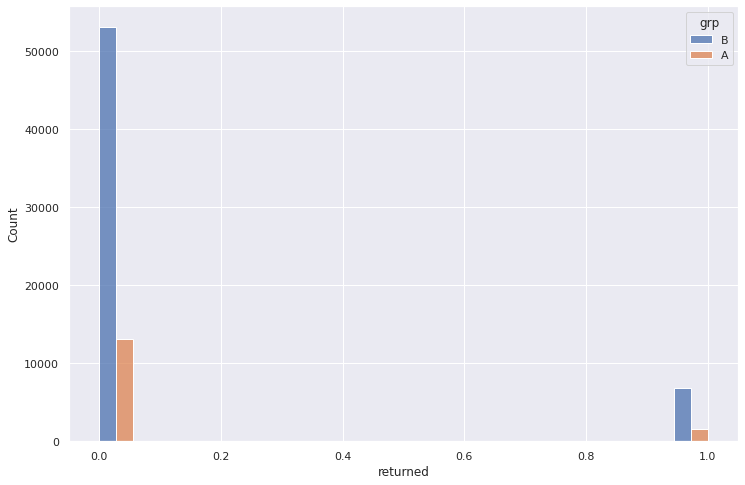

In [105]:
sns.histplot(data=retention_df, x='returned', hue='grp', multiple="dodge");

Применим тест Хи-квадрат и тест пропорций на основе нормального (z) теста

Сначала посмотрим на <b>z-тест пропорций</b>

In [106]:
# Данные взяли из таблицы сопряженности
count, nobs = ((6803, 1538),   # Первая строка кол-во вернувшихся пользовалетей, вторая - общее кол-во польщователей в группах
               (59883, 14693)) # Первый столбец матрицы группа В, второй - А

In [107]:
# Левосторонняя альтернатива показывает, что проверяем альтернативную гипотезу именно о том, что retention у В группы меньше, 
# чем у группы А 
prop.proportions_ztest(count, nobs, alternative='smaller')

(3.0772633669004743, 0.9989554468333867)

Получаем уровень значимости 0.99 - следовательно не можем принять альтернативную гипотезу о том, что retention у В группы меньше, чем у А.

Посмотрим теперь на <b>критерий Хи-квадрат</b>

In [108]:
exp, obs, stat = pg.chi2_independence(data=retention_df, x='grp', y='returned')
stat

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,9.379875,1.0,0.002194,0.011215,0.864920
1,cressie-read,0.666667,9.424791,1.0,0.002141,0.011242,0.866505
2,log-likelihood,0.000000,9.516250,1.0,0.002037,0.011296,0.869680
3,freeman-tukey,-0.500000,9.586295,1.0,0.001960,0.011338,0.872066
4,mod-log-likelihood,-1.000000,9.657611,1.0,0.001886,0.011380,0.874455
5,neyman,-2.000000,9.804152,1.0,0.001741,0.011466,0.879240


Хи-квадрат только ищет отличия между двумя категориальными переменными. В нашем тесте он это нашел (p-val < 0.05), однако мы не можем сказать, что retention упал. Мы только поняли, что они различаются. И исходя из вручную рассчитанного retention, графика распределения и теста пропорций можно сказать, что retention группы B больше, чем у группы А.

Следовательно наша guardrail метрика не упала, целевая метрика увеличилась. Можно запускать новую механику на всех пользователей.